In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,15
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score,accuracy_score ,confusion_matrix

import warnings
warnings.filterwarnings("ignore")

from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import ClusterCentroids , NearMiss

from tqdm.notebook import tqdm ,tnrange

/kaggle/input/healthcareanalyticsii/train_data_dict.csv
/kaggle/input/healthcareanalyticsii/sample_submission.csv
/kaggle/input/healthcareanalyticsii/test.csv
/kaggle/input/healthcareanalyticsii/train.csv
/kaggle/input/fork-of-lets-get-rid-of-the-patients/__results__.html
/kaggle/input/fork-of-lets-get-rid-of-the-patients/custom.css
/kaggle/input/fork-of-lets-get-rid-of-the-patients/combined.csv
/kaggle/input/fork-of-lets-get-rid-of-the-patients/__notebook__.ipynb
/kaggle/input/fork-of-lets-get-rid-of-the-patients/__output__.json


In [2]:
train_data = pd.read_csv('../input/healthcareanalyticsii/train.csv')
test_data = pd.read_csv('../input/healthcareanalyticsii/test.csv')

In [3]:
print(train_data.shape)
train_data.head()

(318438, 18)


,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


In [4]:
print(test_data.shape)
test_data.head()

(137057, 17)


,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit
0,318439,21,c,3,Z,3,gynecology,S,A,2.0,17006,2.0,Emergency,Moderate,2,71-80,3095.0
1,318440,29,a,4,X,2,gynecology,S,F,2.0,17006,2.0,Trauma,Moderate,4,71-80,4018.0
2,318441,26,b,2,Y,3,gynecology,Q,D,4.0,17006,2.0,Emergency,Moderate,3,71-80,4492.0
3,318442,6,a,6,X,3,gynecology,Q,F,2.0,17006,2.0,Trauma,Moderate,3,71-80,4173.0
4,318443,28,b,11,X,2,gynecology,R,F,2.0,17006,2.0,Trauma,Moderate,4,71-80,4161.0


In [5]:
def nullColumns(train_data):
    list_of_nullcolumns =[]
    for column in train_data.columns:
        total= train_data[column].isna().sum()
        try:
            if total !=0:
                print('Total Na values is {0} for column {1}' .format(total, column))
                list_of_nullcolumns.append(column)
        except:
            print(column,"-----",total)
    print('\n')
    return list_of_nullcolumns


def percentMissingFeature(data):
    data_na = (data.isnull().sum() / len(data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    return data_na


def plotMissingFeature(data_na):
    f, ax = plt.subplots(figsize=(15, 12))
    plt.xticks(rotation='90')
    if(data_na.empty ==False):
        sns.barplot(x=data_na.index, y=data_na)
        plt.xlabel('Features', fontsize=15)
        plt.ylabel('Percent of missing values', fontsize=15)
        plt.title('Percent missing data by feature', fontsize=15)

In [6]:
print('train data')
print(nullColumns(train_data))
print(percentMissingFeature(train_data))
print('\n')
print('test_data')
print(nullColumns(test_data))
print(percentMissingFeature(test_data))

train data
Total Na values is 113 for column Bed Grade
Total Na values is 4532 for column City_Code_Patient


['Bed Grade', 'City_Code_Patient']
City_Code_Patient    1.423197
Bed Grade            0.035486
dtype: float64


test_data
Total Na values is 35 for column Bed Grade
Total Na values is 2157 for column City_Code_Patient


['Bed Grade', 'City_Code_Patient']
City_Code_Patient    1.573798
Bed Grade            0.025537
dtype: float64


Text(0.5, 1.0, 'Stay')

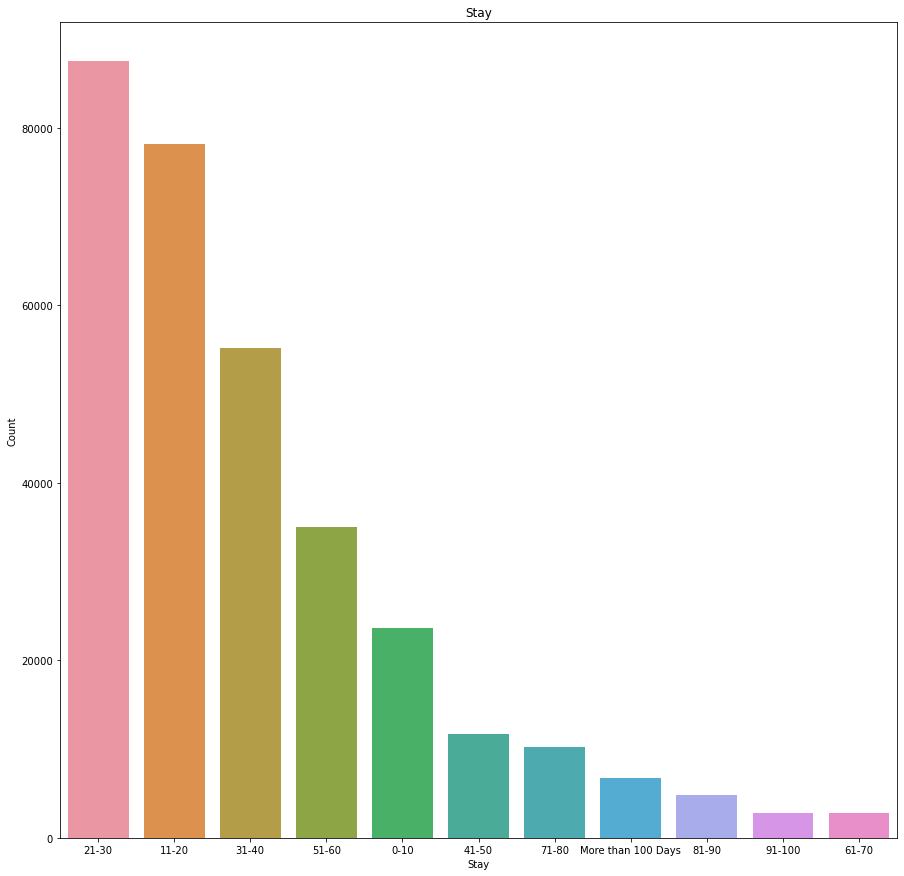

In [7]:
stay = train_data.loc[:,"Stay"].value_counts().rename('Count')
plt.xlabel("Stay")
plt.ylabel('Count')
sns.barplot(stay.index , stay.values).set_title('Stay')

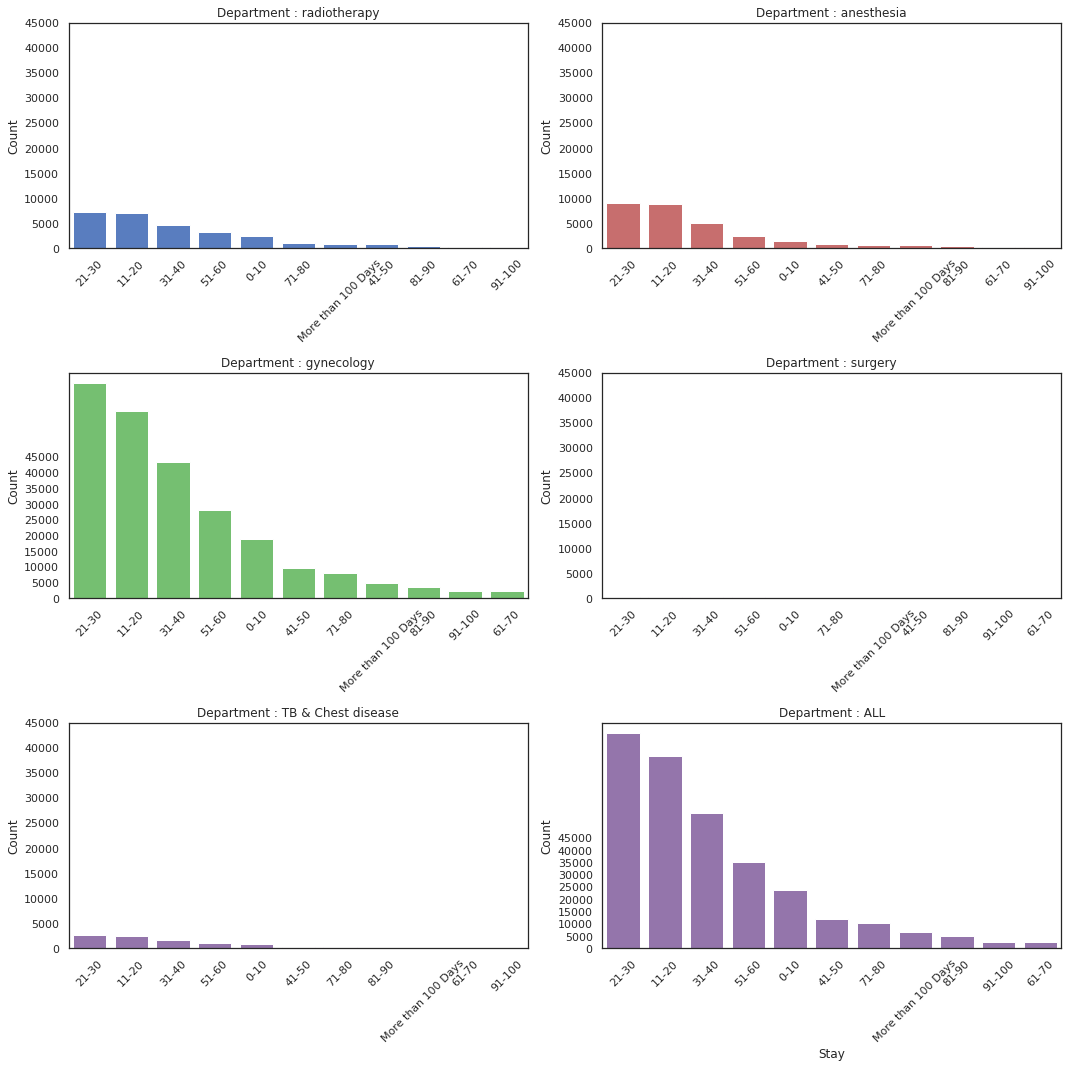

In [8]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(3, 2, figsize=(15, 15))

radiotherapy = train_data[train_data.Department =='radiotherapy']["Stay"].value_counts().rename('Count')

anesthesia = train_data[train_data.Department =='anesthesia']["Stay"].value_counts().rename('Count')

gynecology = train_data[train_data.Department =='gynecology']["Stay"].value_counts().rename('Count')

surgery = train_data[train_data.Department =='surgery']["Stay"].value_counts().rename('Count')

tb = train_data[train_data.Department =='TB & Chest disease']["Stay"].value_counts().rename('Count')

sns.barplot(radiotherapy.index,radiotherapy,  color="b", ax=axes[0, 0]).set_title('Department : radiotherapy')

sns.barplot(anesthesia.index,anesthesia,   color="r", ax=axes[0, 1]).set_title('Department : anesthesia')

sns.barplot(gynecology.index,gynecology,  color="g", ax=axes[1, 0]).set_title('Department : gynecology')

sns.barplot(surgery.index,surgery, color="m", ax=axes[1, 1]).set_title('Department : surgery')

sns.barplot(tb.index,tb, color="m", ax=axes[2, 0]).set_title('Department : TB & Chest disease')

sns.barplot(stay.index,stay, color="m", ax=axes[2, 1]).set_title('Department : ALL')

plt.xlabel("Stay")

plt.setp(axes,yticks = np.arange(0,50000,5000))

for ax in f.axes:
    
    plt.sca(ax)
    
    plt.xticks(rotation=45)

plt.tight_layout()


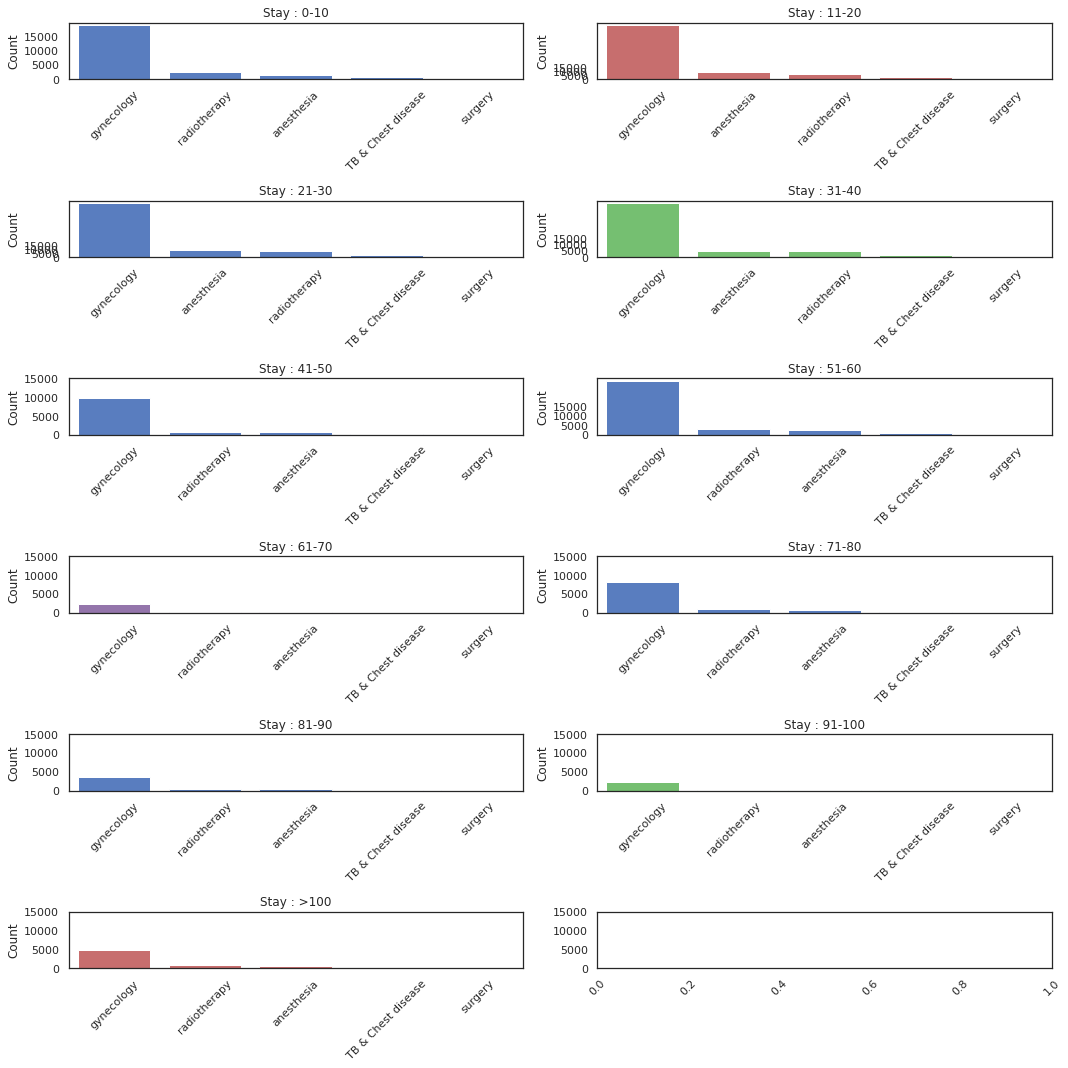

In [9]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(6, 2, figsize=(15, 15))

stay0 = train_data[train_data.Stay =='0-10']["Department"].value_counts().rename('Count')

stay1 = train_data[train_data.Stay =='11-20']["Department"].value_counts().rename('Count')

stay2 = train_data[train_data.Stay =='21-30']["Department"].value_counts().rename('Count')

stay3 = train_data[train_data.Stay =='31-40']["Department"].value_counts().rename('Count')

stay4 = train_data[train_data.Stay =='41-50']["Department"].value_counts().rename('Count')

stay5 = train_data[train_data.Stay =='51-60']["Department"].value_counts().rename('Count')

stay6 = train_data[train_data.Stay =='61-70']["Department"].value_counts().rename('Count')

stay7 = train_data[train_data.Stay =='71-80']["Department"].value_counts().rename('Count')

stay8 = train_data[train_data.Stay =='81-90']["Department"].value_counts().rename('Count')

stay9 = train_data[train_data.Stay =='91-100']["Department"].value_counts().rename('Count')

stay10 = train_data[train_data.Stay =='More than 100 Days']["Department"].value_counts().rename('Count')

sns.barplot(stay0.index,stay0,  color="b", ax=axes[0, 0]).set_title('Stay : 0-10')
                   
sns.barplot(stay1.index,stay2,  color="r", ax=axes[0, 1]).set_title('Stay : 11-20')

sns.barplot(stay2.index,stay2,  color="b", ax=axes[1, 0]).set_title('Stay : 21-30')

sns.barplot(stay3.index,stay3,  color="g", ax=axes[1, 1]).set_title('Stay : 31-40')

sns.barplot(stay4.index,stay4,  color="b", ax=axes[2, 0]).set_title('Stay : 41-50')

sns.barplot(stay5.index,stay5,  color="b", ax=axes[2, 1]).set_title('Stay : 51-60')

sns.barplot(stay6.index,stay6,  color="m", ax=axes[3, 0]).set_title('Stay : 61-70')

sns.barplot(stay7.index,stay7, color="b", ax=axes[3, 1]).set_title('Stay : 71-80')

sns.barplot(stay8.index,stay8,  color="b", ax=axes[4, 0]).set_title('Stay : 81-90')

sns.barplot(stay9.index,stay9,  color="g", ax=axes[4, 1]).set_title('Stay : 91-100')

sns.barplot(stay10.index,stay10, color="r", ax=axes[5, 0]).set_title('Stay : >100')

plt.setp(axes, yticks = np.arange(0,20000,5000))


for ax in f.axes:
    
    plt.sca(ax)
    
    plt.xticks(rotation=45)

plt.tight_layout()

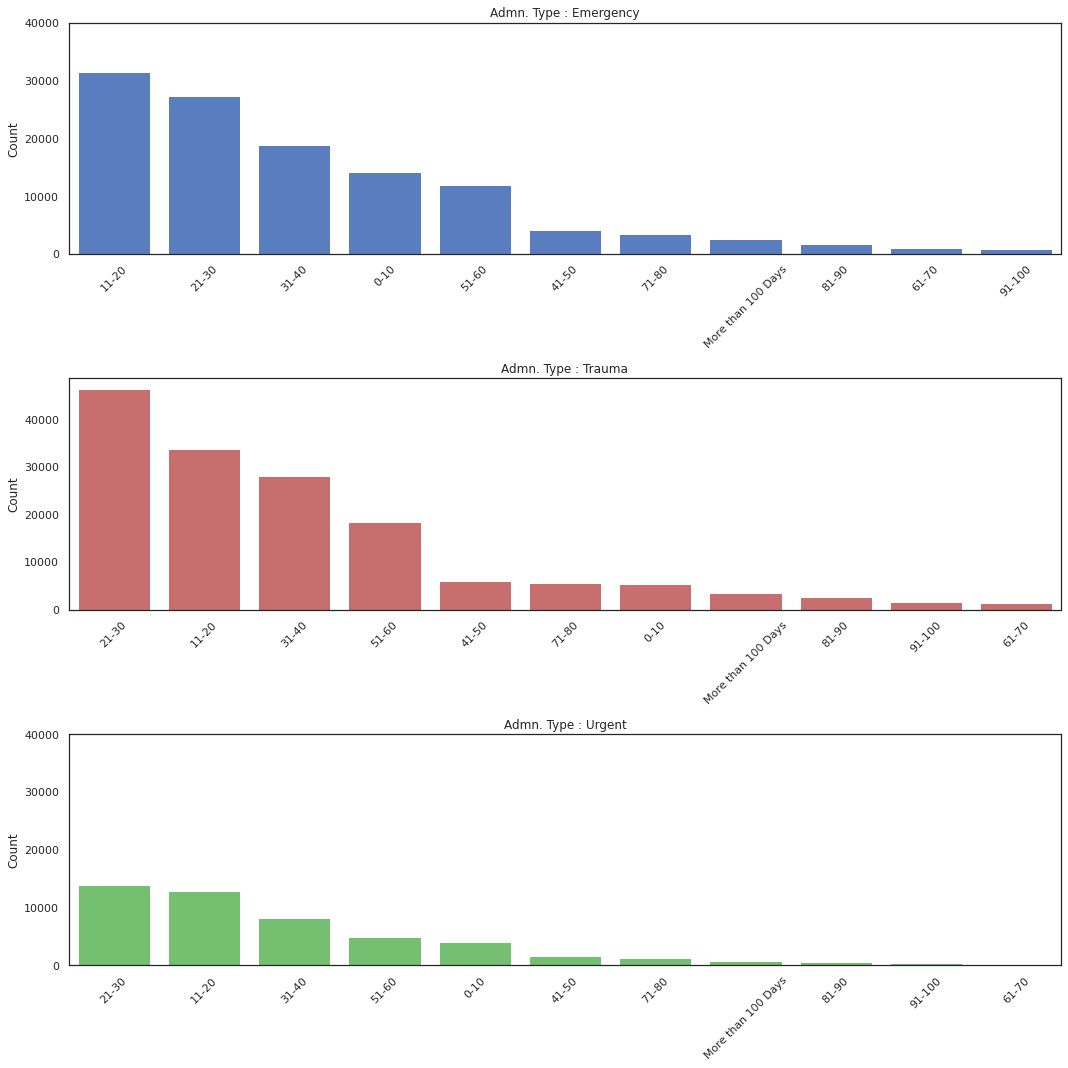

In [10]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(3, 1, figsize=(15, 15))

emergency = train_data[train_data['Type of Admission'] =='Emergency']["Stay"].value_counts().rename('Count')

trauma = train_data[train_data['Type of Admission'] =='Trauma']["Stay"].value_counts().rename('Count')

urgent = train_data[train_data['Type of Admission'] =='Urgent']["Stay"].value_counts().rename('Count')

sns.barplot(emergency.index,emergency,  color="b", ax=axes[0]).set_title('Admn. Type : Emergency')

sns.barplot(trauma.index,trauma,   color="r", ax=axes[1]).set_title('Admn. Type : Trauma')

sns.barplot(urgent.index,urgent,  color="g", ax=axes[2]).set_title('Admn. Type : Urgent')

plt.setp(axes, yticks = np.arange(0,50000,10000))

for ax in f.axes:
    
    plt.sca(ax)
    
    plt.xticks(rotation=45)

plt.tight_layout()

In [11]:
train_data['City_Code_Patient'] = train_data['City_Code_Patient'].fillna(-1)
train_data['Bed Grade'] = train_data['Bed Grade'].fillna(-1)

In [12]:
test_data['City_Code_Patient'] = test_data['City_Code_Patient'].fillna(-1)
test_data['Bed Grade'] = test_data['Bed Grade'].fillna(-1)

In [13]:
cat_cols = ['Hospital_code','Hospital_type_code','City_Code_Hospital','Hospital_region_code'
            ,'Department','Ward_Type','Ward_Facility_Code','Bed Grade','City_Code_Patient',
           # 'Type of Admission','Severity of Illness',
            'Age']

In [14]:
label = 'Stay'

In [15]:
def encode_cat_cols(train, test, cat_cols): #target

    train_df = train_data.copy()
    
    test_df = test_data.copy()
    
    # Making a dictionary to store all the labelencoders for categroical columns to transform them later.
    
    le_dict = {}

    for col in cat_cols:
        
        le = LabelEncoder()
        
        le.fit(train_df[col].unique().tolist() + test_df[col].unique().tolist())
        
        train_df[col] = le.transform(train_df[[col]])
        
        test_df[col] = le.transform(test_df[[col]])

        le_dict[col] = le

    le = LabelEncoder()
    
    train_df[label] = le.fit_transform(train_df[[label]])
    
    le_dict[label] = le
    
    train_df['Type of Admission'] = train_df['Type of Admission'].map({'Urgent':0,'Emergency':1,'Trauma':2})
    
    train_df['Severity of Illness'] = train_df['Severity of Illness'].map({'Minor':0,'Moderate':1,'Extreme':2})
    
    test_df['Type of Admission'] = test_df['Type of Admission'].map({'Urgent':0,'Emergency':1,'Trauma':2})
    
    test_df['Severity of Illness'] = test_df['Severity of Illness'].map({'Minor':0,'Moderate':1,'Extreme':2})
    
    return train_df, test_df, le_dict

In [16]:
def feature_importance(model, X_train):

    print(model.feature_importances_)
    
    names = X_train.columns.values
    
    ticks = [i for i in range(len(names))]
    
    plt.bar(ticks, model.feature_importances_)
    
    plt.xticks(ticks, names,rotation = 90)
    
    plt.show()

In [17]:
train_df, test_df, le_dict = encode_cat_cols(train_data,test_data,cat_cols)

In [18]:
#After Feature Engineering
# https://www.kaggle.com/gcspkmdr/lets-get-rid-of-the-patients-feature-engineering

combined_data = pd.read_csv('/kaggle/input/fork-of-lets-get-rid-of-the-patients/combined.csv')

In [19]:
train_df = combined_data[combined_data['train']==1]

test_df = combined_data[combined_data['train']==0]

In [20]:
train_df.drop(columns = ['case_id','train','patientid','Hospital_code',
                         'Hospital_type_code','City_Code_Hospital','Ward_Facility_Code'],inplace = True)

target = train_df.pop('Stay')

test_df.drop(columns = ['case_id','train','Stay','patientid','Hospital_code',
                        'Hospital_type_code','City_Code_Hospital','Ward_Facility_Code'],inplace = True)








































# Cross Validation
![](https://4.bp.blogspot.com/-wpr6O3EBAfU/WbHyt6UCOVI/AAAAAAAAjPw/Y1DaO6qcV8oDYjJHzJ1PaPB2EXHmYtBBQCLcBGAs/s1600/%25E6%2593%25B7%25E5%258F%2596.JPG)

* **The CV score generated using the methodology shown in the above figure is a better indicator of model performance than public LB**

In [21]:
cat_features = ['Hospital_region_code','Department','Ward_Type','Bed Grade','City_Code_Patient','Type of Admission','Severity of Illness','Age']

Fold 0
 rows of train = 175140 rows of holdout = 143298
0:	learn: 0.2837216	test: 0.2825929	best: 0.2825929 (0)	total: 57.1ms	remaining: 57s
100:	learn: 0.4472593	test: 0.4302154	best: 0.4302991 (98)	total: 4.81s	remaining: 42.8s
200:	learn: 0.4664154	test: 0.4329509	best: 0.4331184 (189)	total: 9.76s	remaining: 38.8s
300:	learn: 0.4827852	test: 0.4339698	best: 0.4346048 (279)	total: 14.3s	remaining: 33.3s
bestTest = 0.4346048096
bestIteration = 279
Shrink model to first 280 iterations.
CatBoost Val CV= 43.46048095577049
[0.55868547 3.38714852 2.26772283 8.83230276 3.51184274 0.5531744
 3.47206496 2.52710285 1.63828714 4.12160854 5.15788084 1.0748962
 0.39998639 0.65475661 2.08081185 0.70892301 1.74209566 1.02875101
 1.60449572 3.29027018 1.52581429 0.84711849 0.37316694 0.9264339
 2.61757096 1.5029904  1.07535859 0.62678942 0.91209402 0.61000939
 0.41746589 0.77021204 1.16568761 0.25196471 0.76944217 0.26947813
 0.22252392 0.28187642 2.34720857 4.62704619 3.034994   3.96135738
 0.8247

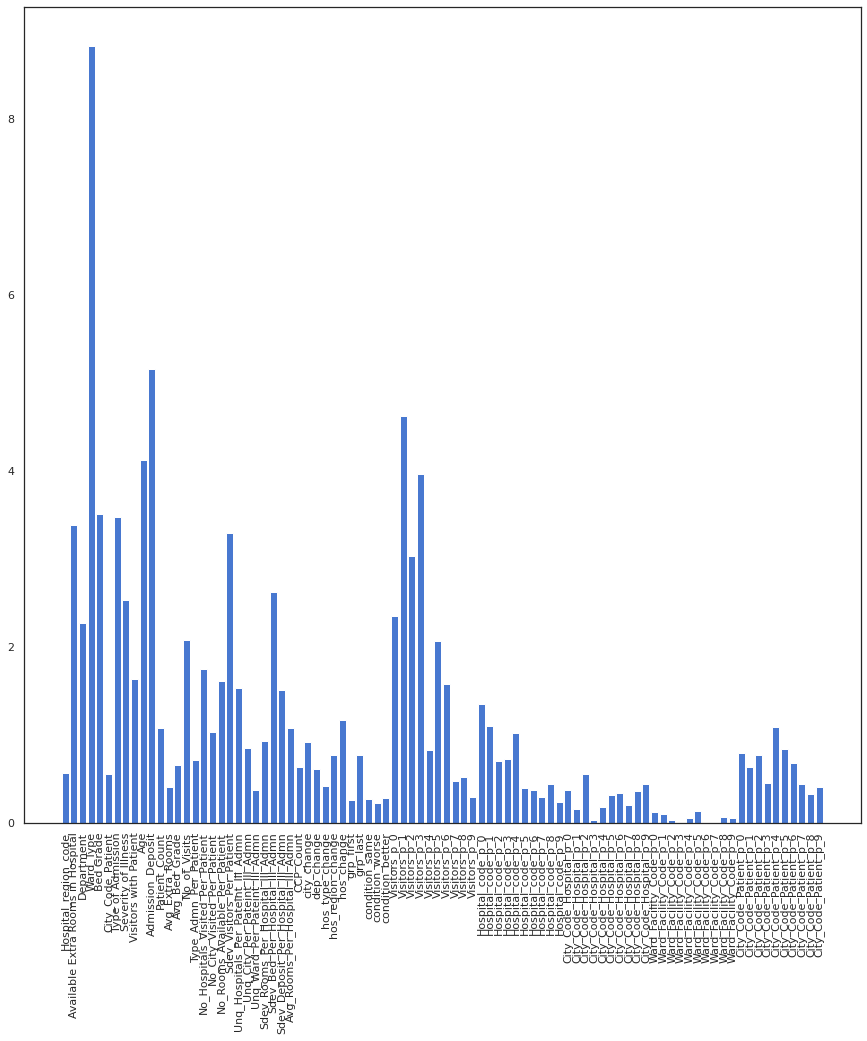

####################################################################################################
Fold 1
 rows of train = 175140 rows of holdout = 143298
0:	learn: 0.2835560	test: 0.2827604	best: 0.2827604 (0)	total: 50.4ms	remaining: 50.3s
100:	learn: 0.4470424	test: 0.4300688	best: 0.4300688 (100)	total: 4.78s	remaining: 42.5s
200:	learn: 0.4664954	test: 0.4334045	best: 0.4335371 (195)	total: 10.4s	remaining: 41.4s
300:	learn: 0.4825797	test: 0.4344792	best: 0.4346676 (277)	total: 15.2s	remaining: 35.3s
400:	learn: 0.4974706	test: 0.4352119	best: 0.4352538 (399)	total: 20s	remaining: 29.8s
bestTest = 0.4355817946
bestIteration = 426
Shrink model to first 427 iterations.
CatBoost Val CV= 43.55817945819202
####################################################################################################
Fold 2
 rows of train = 175140 rows of holdout = 143298
0:	learn: 0.2841041	test: 0.2810228	best: 0.2810228 (0)	total: 175ms	remaining: 2m 54s
100:	learn: 0.4484355	test: 0.4320926

In [22]:
%%time

##CatBoost

scores = []

avg_loss = []

X_train_cv,y_train_cv = train_df.copy(), target.copy()

sssf = StratifiedShuffleSplit(n_splits=5, test_size = 0.45 ,random_state=1)

for i, (idxT, idxV) in enumerate(sssf.split(X_train_cv, y_train_cv)):
    
    print('Fold',i)
    
    print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
    
    clf = CatBoostClassifier(iterations=1000,
                            learning_rate=0.1,
                            random_strength=0.1,
                            depth=8,
                            loss_function='MultiClass',
                            eval_metric='Accuracy',
                            leaf_estimation_method='Newton',
                            task_type = 'GPU',
                            random_state = 1,
                            cat_features =cat_features
                            )    
    
    h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT],
                eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
               early_stopping_rounds=50,verbose = 100)
    
    acc = accuracy_score(y_train_cv.iloc[idxV],np.argmax(clf.predict_proba(X_train_cv.iloc[idxV]),axis =1))*100
    
    scores.append(acc)
    
    avg_loss.append(clf.best_score_['validation']['MultiClass'])
    
    print ('CatBoost Val CV=',acc)
    
    if i==0:
        feature_importance(clf,X_train_cv)
    
    print('#'*100)

print("Multi Log Loss Stats {0:.5f},{1:.5f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))

print('%.3f (%.3f)' % (np.array(scores).mean(), np.array(scores).std()))

# Model Building

In [23]:
trees = 5

seeds = [32,432,73]

submission = pd.read_csv('../input/healthcareanalyticsii/sample_submission.csv')

probs = np.zeros(shape=(len(test_df),11))

submission_probs = pd.DataFrame(columns = ['case_id'] + list(le_dict['Stay'].classes_))

submission_probs.iloc[:,0] = submission.iloc[:,0]

submission_probs.iloc[:,1:] = 0

In [24]:
%%time

##LightGBM

#groups = train_df['patientid'].values

scores = []

avg_loss = []

submission_name = [] 

X_train_cv,y_train_cv = train_df.copy(), target.copy()

for seed in tnrange(len(seeds)):

    sssf = StratifiedShuffleSplit(n_splits=5, test_size = 0.3 ,random_state=seeds[seed])

    for j, (idxT, idxV) in tqdm(enumerate(sssf.split(X_train_cv, y_train_cv))):

        print('Fold',j)

        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))

        model_cat = [0] *trees

        for i in tnrange(trees):

            print('Tree',i)

            model_cat[i] = CatBoostClassifier(iterations=1000,
                                              learning_rate=0.1,
                                              random_strength=0.1,
                                              depth=8,
                                              loss_function='MultiClass',
                                              eval_metric='Accuracy',
                                              leaf_estimation_method='Newton',
                                              task_type = 'GPU',
                                              random_state = i*27,
                                              cat_features = cat_features
                                            )    
    
            model_cat[i].fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT],
                eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
               early_stopping_rounds=50,verbose = 100)

            probs_file_name = 'probs_'+str(seeds[seed])+'_'+str(j)+'_'+str(i)+".csv"
            
            submisssion_file_name  = 'submission_'+str(seeds[seed])+'_'+str(j)+'_'+str(i)+".csv"
            
            model_cat_probs = model_cat[i].predict_proba(test_df)
            
            submission_probs.iloc[:,1:] = model_cat_probs
            
            # probablity file per seed per split per tree
            submission_probs.to_csv(probs_file_name,index = False)
            
            submission['Stay'] = le_dict['Stay'].inverse_transform(np.argmax(model_cat_probs,axis =1))
            
            # submission file per seed per split per tree
            submission.to_csv(submisssion_file_name,index =False)
            
            probs += model_cat_probs
            
            acc = accuracy_score(y_train_cv.iloc[idxV],np.argmax(model_cat[i].predict_proba(X_train_cv.iloc[idxV]),axis =1))*100
            
            scores.append(acc)
            
            submission_name.append(submisssion_file_name)
            
            avg_loss.append(model_cat[i].best_score_['validation']['MultiClass'])

            print ('CatBoost Accuracy Split =',acc)
            
            print('#'*100)
    

print('%.3f (%.3f)' % (np.array(scores).mean(), np.array(scores).std()))

Fold 0
 rows of train = 222906 rows of holdout = 95532


Tree 0
0:	learn: 0.2837295	test: 0.2826487	best: 0.2826487 (0)	total: 50.6ms	remaining: 50.5s
100:	learn: 0.4450082	test: 0.4322531	best: 0.4322531 (100)	total: 5.36s	remaining: 47.7s
200:	learn: 0.4617911	test: 0.4356237	best: 0.4356237 (200)	total: 10.1s	remaining: 40.2s
300:	learn: 0.4747337	test: 0.4370891	best: 0.4373822 (296)	total: 15.2s	remaining: 35.3s
400:	learn: 0.4876630	test: 0.4378323	best: 0.4379161 (377)	total: 19.9s	remaining: 29.7s
bestTest = 0.4379160909
bestIteration = 377
Shrink model to first 378 iterations.
CatBoost Accuracy Split = 43.79160909433488
####################################################################################################
Tree 1
0:	learn: 0.2831283	test: 0.2823557	best: 0.2823557 (0)	total: 47.4ms	remaining: 47.3s
100:	learn: 0.4461028	test: 0.4321589	best: 0.4321589 (100)	total: 5.29s	remaining: 47.1s
200:	learn: 0.4627197	test: 0.4353096	best: 0.4354771 (196)	total: 10.1s	remaining: 40s
bestTest = 0.4363982749
bestIteration = 247
Shr

Tree 0
0:	learn: 0.2825900	test: 0.2838630	best: 0.2838630 (0)	total: 47.8ms	remaining: 47.7s
100:	learn: 0.4465245	test: 0.4305678	best: 0.4307457 (99)	total: 6.41s	remaining: 57.1s
200:	learn: 0.4629979	test: 0.4337395	best: 0.4339070 (197)	total: 11.4s	remaining: 45.1s
300:	learn: 0.4767570	test: 0.4347130	best: 0.4352050 (262)	total: 16.5s	remaining: 38.3s
bestTest = 0.4352049575
bestIteration = 262
Shrink model to first 263 iterations.
CatBoost Accuracy Split = 43.520495750115145
####################################################################################################
Tree 1
0:	learn: 0.2830117	test: 0.2833501	best: 0.2833501 (0)	total: 50.8ms	remaining: 50.7s
100:	learn: 0.4466412	test: 0.4302433	best: 0.4302433 (100)	total: 5s	remaining: 44.5s
200:	learn: 0.4624012	test: 0.4329858	best: 0.4337709 (192)	total: 10.5s	remaining: 41.6s
bestTest = 0.4337708831
bestIteration = 192
Shrink model to first 193 iterations.
CatBoost Accuracy Split = 43.37708830548926
############

Tree 0
0:	learn: 0.2830655	test: 0.2822510	best: 0.2822510 (0)	total: 50.2ms	remaining: 50.2s
100:	learn: 0.4463002	test: 0.4310493	best: 0.4310493 (100)	total: 4.96s	remaining: 44.1s
200:	learn: 0.4618943	test: 0.4342315	best: 0.4346083 (196)	total: 10.2s	remaining: 40.4s
300:	learn: 0.4755951	test: 0.4354457	best: 0.4354457 (270)	total: 15.2s	remaining: 35.2s
400:	learn: 0.4876136	test: 0.4361889	best: 0.4363250 (393)	total: 20.2s	remaining: 30.2s
bestTest = 0.4367855797
bestIteration = 435
Shrink model to first 436 iterations.
CatBoost Accuracy Split = 43.67960473977306
####################################################################################################
Tree 1
0:	learn: 0.2835590	test: 0.2828686	best: 0.2828686 (0)	total: 78.3ms	remaining: 1m 18s
100:	learn: 0.4460580	test: 0.4304840	best: 0.4304840 (100)	total: 5.33s	remaining: 47.5s
200:	learn: 0.4613424	test: 0.4342419	best: 0.4343466 (193)	total: 10.7s	remaining: 42.7s
300:	learn: 0.4746485	test: 0.4347548	best: 

Tree 0
0:	learn: 0.2831552	test: 0.2815601	best: 0.2815601 (0)	total: 47.9ms	remaining: 47.9s
100:	learn: 0.4459952	test: 0.4302119	best: 0.4302119 (100)	total: 5.37s	remaining: 47.8s
200:	learn: 0.4636528	test: 0.4334045	best: 0.4334045 (200)	total: 10.3s	remaining: 40.8s
300:	learn: 0.4763847	test: 0.4337499	best: 0.4340326 (274)	total: 15.6s	remaining: 36.1s
400:	learn: 0.4890268	test: 0.4348805	best: 0.4350061 (383)	total: 20.3s	remaining: 30.3s
500:	learn: 0.5005339	test: 0.4351945	best: 0.4358016 (465)	total: 25.4s	remaining: 25.3s
bestTest = 0.4358016162
bestIteration = 465
Shrink model to first 466 iterations.
CatBoost Accuracy Split = 43.58016162123686
####################################################################################################
Tree 1
0:	learn: 0.2840749	test: 0.2820102	best: 0.2820102 (0)	total: 51.2ms	remaining: 51.2s
100:	learn: 0.4455286	test: 0.4303689	best: 0.4303689 (100)	total: 5.17s	remaining: 46s
200:	learn: 0.4621993	test: 0.4326822	best: 0.4

Tree 0
0:	learn: 0.2833257	test: 0.2816543	best: 0.2816543 (0)	total: 50.6ms	remaining: 50.6s
100:	learn: 0.4461656	test: 0.4316459	best: 0.4316459 (100)	total: 4.93s	remaining: 43.9s
200:	learn: 0.4618225	test: 0.4351631	best: 0.4351631 (200)	total: 10.2s	remaining: 40.5s
bestTest = 0.4354247791
bestIteration = 208
Shrink model to first 209 iterations.
CatBoost Accuracy Split = 43.542477913159985
####################################################################################################
Tree 1
0:	learn: 0.2835769	test: 0.2821672	best: 0.2821672 (0)	total: 48.9ms	remaining: 48.9s
100:	learn: 0.4458337	test: 0.4312272	best: 0.4312272 (100)	total: 5.78s	remaining: 51.4s
200:	learn: 0.4627287	test: 0.4342105	best: 0.4344513 (196)	total: 10.7s	remaining: 42.6s
300:	learn: 0.4761559	test: 0.4348909	best: 0.4351840 (297)	total: 15.3s	remaining: 35.6s
400:	learn: 0.4885198	test: 0.4363145	best: 0.4363564 (369)	total: 20.5s	remaining: 30.6s
bestTest = 0.4363564041
bestIteration = 369


Fold 0
 rows of train = 222906 rows of holdout = 95532


Tree 0
0:	learn: 0.2830162	test: 0.2824289	best: 0.2824289 (0)	total: 84.9ms	remaining: 1m 24s
100:	learn: 0.4457439	test: 0.4301386	best: 0.4301805 (96)	total: 5.63s	remaining: 50.1s
200:	learn: 0.4623832	test: 0.4346188	best: 0.4347339 (195)	total: 11.6s	remaining: 46.1s
300:	learn: 0.4750568	test: 0.4361052	best: 0.4364506 (292)	total: 16.6s	remaining: 38.5s
bestTest = 0.4364506134
bestIteration = 292
Shrink model to first 293 iterations.
CatBoost Accuracy Split = 43.64506134070259
####################################################################################################
Tree 1
0:	learn: 0.2836128	test: 0.2822300	best: 0.2822300 (0)	total: 52.8ms	remaining: 52.7s
100:	learn: 0.4459324	test: 0.4304317	best: 0.4305887 (99)	total: 5.42s	remaining: 48.3s
200:	learn: 0.4615174	test: 0.4347758	best: 0.4347758 (200)	total: 10.6s	remaining: 42.2s
300:	learn: 0.4742044	test: 0.4349747	best: 0.4356760 (265)	total: 15.8s	remaining: 36.6s
bestTest = 0.4356760039
bestIteration = 265
Sh

Tree 0
0:	learn: 0.2829309	test: 0.2818951	best: 0.2818951 (0)	total: 64.3ms	remaining: 1m 4s
100:	learn: 0.4452146	test: 0.4301386	best: 0.4301386 (100)	total: 5.13s	remaining: 45.7s
200:	learn: 0.4626300	test: 0.4329230	best: 0.4331742 (189)	total: 9.95s	remaining: 39.6s
300:	learn: 0.4760706	test: 0.4339593	best: 0.4341791 (278)	total: 15.1s	remaining: 35.1s
400:	learn: 0.4891703	test: 0.4343047	best: 0.4349433 (356)	total: 19.8s	remaining: 29.6s
bestTest = 0.4349432651
bestIteration = 356
Shrink model to first 357 iterations.
CatBoost Accuracy Split = 43.49432650839509
####################################################################################################
Tree 1
0:	learn: 0.2832629	test: 0.2813089	best: 0.2813089 (0)	total: 47.7ms	remaining: 47.7s
100:	learn: 0.4458023	test: 0.4306410	best: 0.4309446 (99)	total: 5.37s	remaining: 47.8s
200:	learn: 0.4629306	test: 0.4337185	best: 0.4338546 (183)	total: 10.8s	remaining: 42.9s
300:	learn: 0.4769858	test: 0.4347967	best: 0.

Tree 0
0:	learn: 0.2827156	test: 0.2831826	best: 0.2831826 (0)	total: 49.8ms	remaining: 49.7s
100:	learn: 0.4453851	test: 0.4324729	best: 0.4324729 (100)	total: 5.27s	remaining: 46.9s
200:	learn: 0.4625762	test: 0.4350270	best: 0.4351631 (196)	total: 11.3s	remaining: 45s
300:	learn: 0.4757970	test: 0.4364715	best: 0.4364715 (300)	total: 16.3s	remaining: 37.9s
bestTest = 0.4367855797
bestIteration = 341
Shrink model to first 342 iterations.
CatBoost Accuracy Split = 43.67855797010426
####################################################################################################
Tree 1
0:	learn: 0.2833616	test: 0.2831303	best: 0.2831303 (0)	total: 51.4ms	remaining: 51.3s
100:	learn: 0.4459503	test: 0.4322007	best: 0.4322007 (100)	total: 5.07s	remaining: 45.1s
200:	learn: 0.4622531	test: 0.4355399	best: 0.4359586 (185)	total: 10.1s	remaining: 40.2s
bestTest = 0.4367123058
bestIteration = 237
Shrink model to first 238 iterations.
CatBoost Accuracy Split = 43.671230582422645
##########

Tree 0
0:	learn: 0.2830431	test: 0.2816334	best: 0.2816334 (0)	total: 51.8ms	remaining: 51.8s
100:	learn: 0.4449589	test: 0.4312586	best: 0.4312586 (100)	total: 5.36s	remaining: 47.7s
200:	learn: 0.4614815	test: 0.4332789	best: 0.4335720 (195)	total: 10.1s	remaining: 40.3s
300:	learn: 0.4747651	test: 0.4343047	best: 0.4347758 (265)	total: 15.2s	remaining: 35.4s
bestTest = 0.4347757819
bestIteration = 265
Shrink model to first 266 iterations.
CatBoost Accuracy Split = 43.477578193694264
####################################################################################################
Tree 1
0:	learn: 0.2838012	test: 0.2825545	best: 0.2825545 (0)	total: 49.7ms	remaining: 49.7s
100:	learn: 0.4456183	test: 0.4296571	best: 0.4297827 (99)	total: 5.13s	remaining: 45.7s
200:	learn: 0.4624057	test: 0.4324834	best: 0.4329753 (188)	total: 10.6s	remaining: 42.1s
bestTest = 0.4329753381
bestIteration = 188
Shrink model to first 189 iterations.
CatBoost Accuracy Split = 43.297533810660305
########

Tree 0
0:	learn: 0.2828098	test: 0.2826069	best: 0.2826069 (0)	total: 49.4ms	remaining: 49.3s
100:	learn: 0.4451966	test: 0.4323159	best: 0.4325043 (97)	total: 5.04s	remaining: 44.8s
200:	learn: 0.4626479	test: 0.4351526	best: 0.4354562 (187)	total: 11.6s	remaining: 46.2s
300:	learn: 0.4746126	test: 0.4361471	best: 0.4362308 (299)	total: 16.6s	remaining: 38.6s
400:	learn: 0.4863889	test: 0.4363669	best: 0.4369949 (370)	total: 21.9s	remaining: 32.7s
bestTest = 0.4369949336
bestIteration = 370
Shrink model to first 371 iterations.
CatBoost Accuracy Split = 43.700540133149104
####################################################################################################
Tree 1
0:	learn: 0.2834738	test: 0.2815287	best: 0.2815287 (0)	total: 51.3ms	remaining: 51.3s
100:	learn: 0.4450665	test: 0.4317192	best: 0.4317192 (100)	total: 5.12s	remaining: 45.6s
200:	learn: 0.4615847	test: 0.4344618	best: 0.4346083 (189)	total: 10.6s	remaining: 42s
300:	learn: 0.4750253	test: 0.4361994	best: 0.4

Fold 0
 rows of train = 222906 rows of holdout = 95532


Tree 0
0:	learn: 0.2840345	test: 0.2809634	best: 0.2809634 (0)	total: 50.3ms	remaining: 50.3s
100:	learn: 0.4449678	test: 0.4303479	best: 0.4304108 (99)	total: 5.29s	remaining: 47.1s
200:	learn: 0.4627421	test: 0.4341687	best: 0.4345769 (196)	total: 10.4s	remaining: 41.4s
300:	learn: 0.4758194	test: 0.4354876	best: 0.4357702 (293)	total: 15.1s	remaining: 35s
bestTest = 0.4363145334
bestIteration = 316
Shrink model to first 317 iterations.
CatBoost Accuracy Split = 43.63145333500816
####################################################################################################
Tree 1
0:	learn: 0.2832539	test: 0.2815601	best: 0.2815601 (0)	total: 50.4ms	remaining: 50.4s
100:	learn: 0.4461073	test: 0.4319181	best: 0.4319181 (100)	total: 5.82s	remaining: 51.8s
200:	learn: 0.4613066	test: 0.4350898	best: 0.4353410 (194)	total: 11.2s	remaining: 44.7s
300:	learn: 0.4742537	test: 0.4367018	best: 0.4370159 (296)	total: 16.2s	remaining: 37.7s
bestTest = 0.437015869
bestIteration = 296
Shrin

Tree 0
0:	learn: 0.2823612	test: 0.2827116	best: 0.2827116 (0)	total: 114ms	remaining: 1m 53s
100:	learn: 0.4456497	test: 0.4314157	best: 0.4314157 (100)	total: 5.78s	remaining: 51.4s
200:	learn: 0.4627197	test: 0.4337081	best: 0.4342419 (171)	total: 11.1s	remaining: 44.2s
bestTest = 0.4342419294
bestIteration = 171
Shrink model to first 172 iterations.
CatBoost Accuracy Split = 43.42419294058536
####################################################################################################
Tree 1
0:	learn: 0.2830700	test: 0.2819579	best: 0.2819579 (0)	total: 50.4ms	remaining: 50.3s
100:	learn: 0.4465290	test: 0.4321275	best: 0.4321275 (100)	total: 5.05s	remaining: 44.9s
200:	learn: 0.4626031	test: 0.4340744	best: 0.4347234 (161)	total: 10.2s	remaining: 40.5s
bestTest = 0.4347234435
bestIteration = 161
Shrink model to first 162 iterations.
CatBoost Accuracy Split = 43.47234434535025
###################################################################################################

Tree 0
0:	learn: 0.2832001	test: 0.2819893	best: 0.2819893 (0)	total: 51.1ms	remaining: 51.1s
100:	learn: 0.4456811	test: 0.4296675	best: 0.4296675 (100)	total: 5.59s	remaining: 49.8s
200:	learn: 0.4620333	test: 0.4328393	best: 0.4329439 (198)	total: 10.3s	remaining: 40.9s
300:	learn: 0.4753842	test: 0.4343780	best: 0.4344618 (290)	total: 15.3s	remaining: 35.6s
bestTest = 0.4348281204
bestIteration = 325
Shrink model to first 326 iterations.
CatBoost Accuracy Split = 43.48281204203827
####################################################################################################
Tree 1
0:	learn: 0.2837609	test: 0.2825231	best: 0.2825231 (0)	total: 48.3ms	remaining: 48.3s
100:	learn: 0.4457753	test: 0.4305154	best: 0.4305154 (100)	total: 4.98s	remaining: 44.4s
200:	learn: 0.4627242	test: 0.4336976	best: 0.4338442 (197)	total: 10.3s	remaining: 41.1s
300:	learn: 0.4754156	test: 0.4348700	best: 0.4350689 (297)	total: 15.9s	remaining: 36.8s
bestTest = 0.4354666499
bestIteration = 309
S

Tree 0
0:	learn: 0.2821817	test: 0.2816543	best: 0.2816543 (0)	total: 50ms	remaining: 49.9s
100:	learn: 0.4441289	test: 0.4324834	best: 0.4324834 (100)	total: 4.82s	remaining: 42.9s
200:	learn: 0.4607772	test: 0.4363459	best: 0.4363459 (200)	total: 9.53s	remaining: 37.9s
300:	learn: 0.4742313	test: 0.4366495	best: 0.4373927 (267)	total: 14.4s	remaining: 33.5s
bestTest = 0.4373927061
bestIteration = 267
Shrink model to first 268 iterations.
CatBoost Accuracy Split = 43.73927061089478
####################################################################################################
Tree 1
0:	learn: 0.2825541	test: 0.2841352	best: 0.2841352 (0)	total: 52.5ms	remaining: 52.4s
100:	learn: 0.4451293	test: 0.4328707	best: 0.4328707 (100)	total: 5.45s	remaining: 48.5s
200:	learn: 0.4609836	test: 0.4360633	best: 0.4360633 (200)	total: 10.3s	remaining: 41s
bestTest = 0.4370472721
bestIteration = 235
Shrink model to first 236 iterations.
CatBoost Accuracy Split = 43.70472721182431
#############

Tree 0
0:	learn: 0.2830027	test: 0.2827744	best: 0.2827744 (0)	total: 53.4ms	remaining: 53.3s
100:	learn: 0.4454658	test: 0.4302537	best: 0.4302537 (100)	total: 5.92s	remaining: 52.7s
200:	learn: 0.4625986	test: 0.4330800	best: 0.4332161 (196)	total: 10.9s	remaining: 43.3s
300:	learn: 0.4752990	test: 0.4343675	best: 0.4346397 (267)	total: 16.2s	remaining: 37.5s
400:	learn: 0.4875777	test: 0.4357911	best: 0.4358854 (399)	total: 20.9s	remaining: 31.1s
bestTest = 0.4358853578
bestIteration = 399
Shrink model to first 400 iterations.
CatBoost Accuracy Split = 43.58748900891848
####################################################################################################
Tree 1
0:	learn: 0.2832091	test: 0.2817590	best: 0.2817590 (0)	total: 108ms	remaining: 1m 48s
100:	learn: 0.4460176	test: 0.4310493	best: 0.4310493 (100)	total: 5.77s	remaining: 51.4s
200:	learn: 0.4621814	test: 0.4331428	best: 0.4331638 (188)	total: 10.7s	remaining: 42.4s
300:	learn: 0.4754874	test: 0.4351631	best: 0

In [25]:
submission_probs.iloc[:,1:] = probs

# probablity combined
submission_probs.to_csv('probs.csv',index =False)

In [26]:
submission['Stay'] = le_dict['Stay'].inverse_transform(np.argmax(probs,axis =1))

# submission file combined            
submission.to_csv('submission.csv',index =False)
            

In [27]:
model_stats = pd.DataFrame({'submission':submission_name,'accuracy':scores,'validation_loss':avg_loss})
model_stats.head()

,submission,accuracy,validation_loss
0,submission_32_0_0.csv,43.791609,1.466823
1,submission_32_0_1.csv,43.639827,1.470282
2,submission_32_0_2.csv,43.691119,1.468661
3,submission_32_0_3.csv,43.682745,1.469377
4,submission_32_0_4.csv,43.721476,1.469339


In [28]:
model_stats.to_csv('model_stats.csv',index =False)